In [2]:
# Importing some things to get rid of warnings
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


In [33]:
# The usual suspects

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans

import SP500models as models

In [34]:
from data_pipeline.processing import sharpe_normalize, risk
from data_pipeline.processing import l2_normalization
from data_pipeline.processing import correlation_histogram
from data_pipeline.processing import market_adjust
from data_pipeline.processing import industry_adjust


# Showing a sample of the KPIs on indsutry clusters

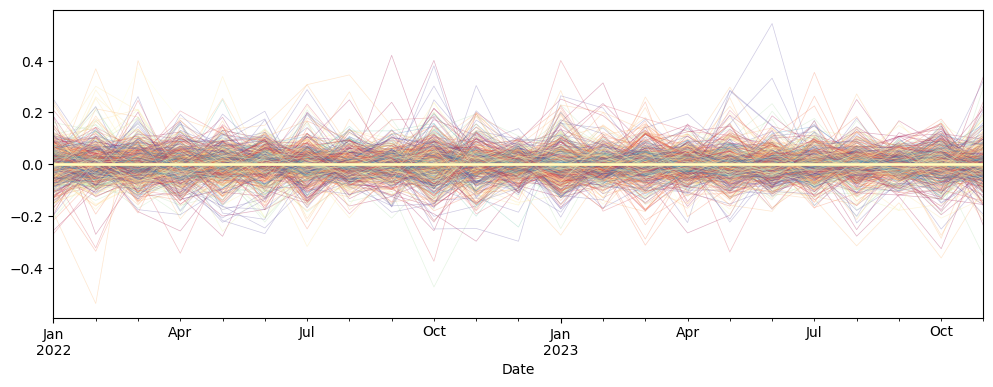

In [35]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")
# baseline clusters = industry
import pickle
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)

ROR = closing_prices.pct_change().dropna()
data = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))

clusters = industry_clusters

name_to_num = {name : i for (i, name) in enumerate(set(industry_clusters.values()))}
clusters = {tick : name_to_num[industry_clusters[tick]] for tick in industry_clusters.keys()}
clust_to_tick = {label : [tick for tick in clusters.keys() if clusters[tick] == label] for label in clusters.values()}

fig, ax = plt.subplots(figsize = (12,4))

for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    data[clust_to_tick[i]].plot(legend = False, color = color, ax=ax, alpha = 0.3, linewidth = 0.5)
for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    data[clust_to_tick[i]].mean(axis = 1).plot(legend = False, color = color, ax=ax, alpha = 1, linewidth = 2)

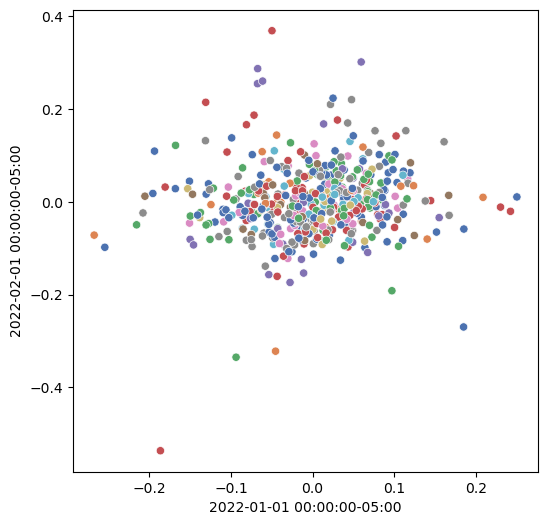

In [39]:
X = data.T
X["cluster"] = list(clusters.values())
cols = X.columns

f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = X, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

import plotly.graph_objects as go

fig = go.Figure(data = [go.Scatter3d(
    x = X[cols[0]],
    y = X[cols[1]],
    z = X[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 4,
        color = X['cluster'],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()

# KMeans Clustering class

In [5]:
class KMeans_Clustering_SP500():
    def __init__(self, n_min = 2, n_max = None,  test_size = 7, use_validation = True):

        self.test_size = 7        
        self.scores = {"DaviesBouldin": [], "CalinskiHarabasz": [], "Silhouette": [], "WCSS" : []}
        self.labels = []
        
        self.n_min = n_min
        self.n_max = n_max+1
        
        self.val = use_validation
        
        self.clusters = []

    def magic_score(self, SH,DB,CH):
        #return ((SH+1)/2) * np.arctan(DB)/(np.pi/2) * np.exp(-CH)
        return (SH+1)/2 * (1/(DB + 1) * (CH/(CH + 1)))
        #return ((SH + 1)/2 +  + )
    # the fit function behaves almost exactly like the usual scikit learn models.

    def fit(self, data):
        self.X = data
        
        # If no maximum clusters given, use the data
        if self.n_max == None:
            self.n_max = len(self.X.columns) - 1
        
        # doing the train-test split
        if self.val == True:
            self.X_train = self.X.iloc[:-self.test_size, :]
            self.X_test = self.X.iloc[-self.test_size:, :]
        
        if self.val == False:
            self.X_train = self.X
            self.X_test = self.X

        
        # perform the kmeans fitting for each n between n_min and n_max:
        for i in range(self.n_min, self.n_max):
            #print(f"Fitting Kmeans with {i} clusters")
            kmeans = KMeans(n_clusters = i, 
                            init='k-means++', 
                            max_iter=300, 
                            n_init=10,
                            random_state=0).fit(self.X_train.T.values)
            # stores the labels of the clustering
            self.labels.append(kmeans.labels_)
            
            cluster = dict(zip(self.X_train.columns, kmeans.labels_))
            self.clusters.append(cluster)
            
            # scores the clustering
            DB_test = davies_bouldin_score(self.X_test.T.values, kmeans.labels_)
            CH_test = calinski_harabasz_score(self.X_test.T.values, kmeans.labels_)
            Sil_test = silhouette_score(self.X_test.T.values, kmeans.labels_, metric='euclidean')
            ElMehdi_test = self.magic_score(Sil_test, CH_test, DB_test)

            self.scores["DaviesBouldin"].append(DB_test)
            self.scores["CalinskiHarabasz"].append(CH_test)
            self.scores["Silhouette"].append(Sil_test)
            self.scores["WCSS"].append(kmeans.inertia_)
            #self.scores["ElMehdi"].append(kmeans.inertia_)
        print("Finished fitting. Generating plots...")
    

    # this bit of code produces pretty pictures.
    def summarize(self, comparison = None):
        comparison_labels = list(comparison.values())

        DB_compare = davies_bouldin_score(self.X_test.values.T, 
                                          comparison_labels)
        CH_compare = calinski_harabasz_score(self.X_test.values.T, 
                                             comparison_labels)
        Sil_compare = silhouette_score(self.X_test.values.T, 
                                       comparison_labels, 
                                       metric='euclidean')
        WCSS_compare = 0

        print(f"DB score for industry clusters: {DB_compare}")
        print(f"CH score for industry clusters: {CH_compare}")
        print(f"Sil score for industry clusters: {Sil_compare}")

        f, axarr = plt.subplots(4, sharex=False, figsize = (6,8))
        f.set_figheight(12)
        f.set_figwidth(12)

        axarr[0].set_title("Comparing scores between kmeans and Industry clusters (in red)")
        axarr[3].set_xlabel("number of clusters in kmeans")

        p1 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["DaviesBouldin"], 
                          ax = axarr[0])
        p1.axhline(y = DB_compare, color = 'red')
        p1.set_ylabel("Davies Bouldin Score")

        p2 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["CalinskiHarabasz"],
                          ax = axarr[1], 
                          legend = False)
        p2.axhline(y = CH_compare, color = 'red')
        print(f"Baseline CH score: {CH_compare}")
        p2.set_ylabel("Calinski Harabasz Score")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                          y = self.scores["Silhouette"], 
                          ax = axarr[2], 
                          legend = False)
        p3.axhline(y = Sil_compare, color = 'red')
        p3.set_ylabel("Silhouette Score")

        p3 = sns.lineplot(x = list(range(self.n_min, self.n_max)), 
                        y = self.scores["WCSS"], 
                        ax = axarr[3], 
                        legend = False)
        p3.axhline(y = WCSS_compare, color = 'red')
        p3.set_ylabel("KMeans Inertia score")

        axarr[0].grid('on', which='major', axis='x' )
        axarr[1].grid('on', which='major', axis='x' )
        axarr[2].grid('on', which='major', axis='x' )
        axarr[3].grid('on', which='major', axis='x' )
        if (self.n_max - self.n_min) > 20:
            axarr[0].minorticks_on()
            axarr[1].minorticks_on()
            axarr[2].minorticks_on()
            axarr[3].minorticks_on()
            
            axarr[0].grid('on', which='minor', axis='x' )
            axarr[1].grid('on', which='minor', axis='x' )
            axarr[2].grid('on', which='minor', axis='x' )
            axarr[3].grid('on', which='minor', axis='x' )



        plt.show()

# Doing the fitting and modeling

For this kmeans, we tune two parameters that do not exist in the usual kmeans algorithm:
- smoothing: the idea is to scale down data that is far from the prediction horizon. This smoothing factor is a number between 0 and 1, and if $r_{-i}$ is the return of investment $i$ days ago, then the smoothing factor transforms the data $r_{-i} \to (smoothing)^i * r_{-i}$. In other words, it exponentially decays the effect of older days
- test_size: since we are doing a time series, all clustering metrics are measured on the validation data instead of the training data. test_size tunes this parameter. This can be toggled on or off with the use_validation argument, which is by default set to True.

# Clustering returns Using KMeans

In [7]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")

closing_prices = closing_prices
ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))
ROR = l2_normalization(ROR)

test_size = 1
kmeansSP500 = KMeans_Clustering_SP500(n_min = 2, 
                                      n_max = 300,
                                      test_size = test_size, 
                                      use_validation = False)
kmeansSP500.fit(ROR)


Finished fitting. Generating plots...


DB score for industry clusters: 26.85330230284991
CH score for industry clusters: 0.22225131956260064
Sil score for industry clusters: -0.02109082488605069
Baseline CH score: 0.22225131956260064


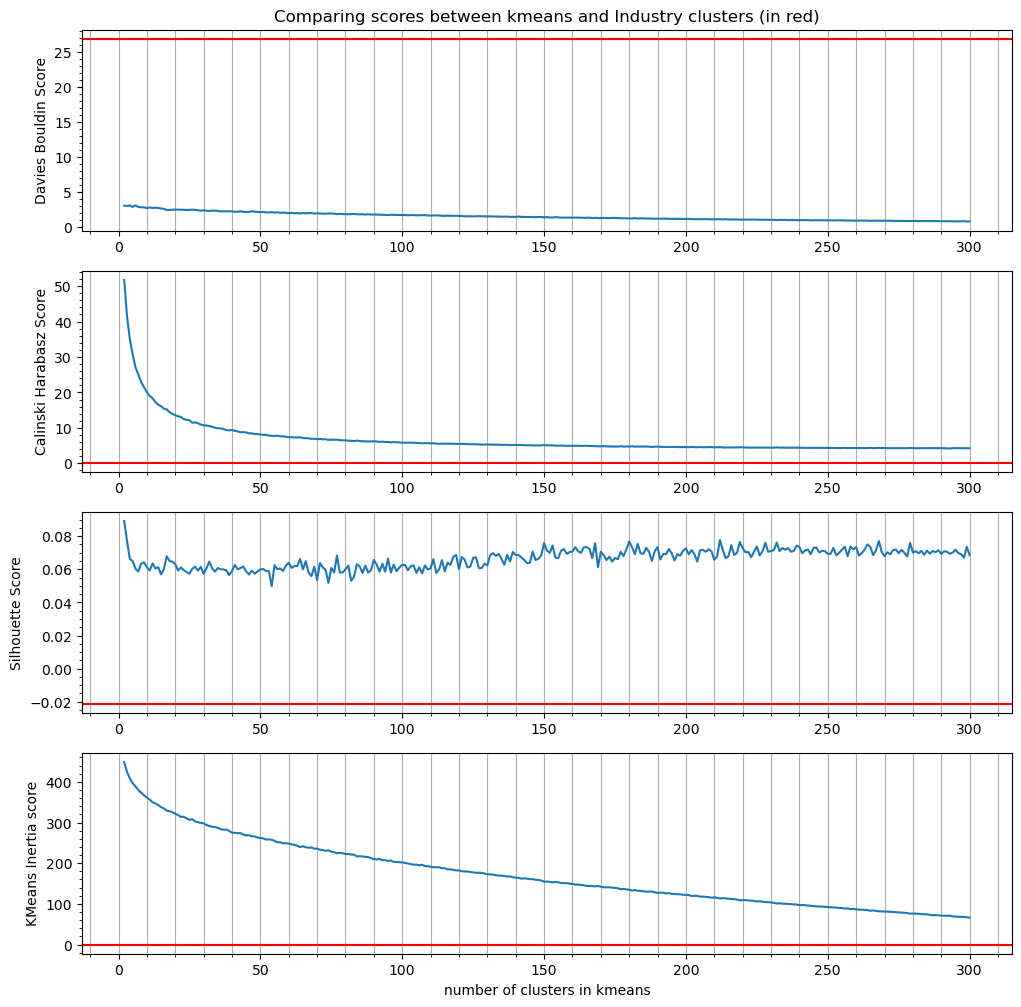

In [8]:
kmeansSP500.summarize(industry_clusters)

0
190


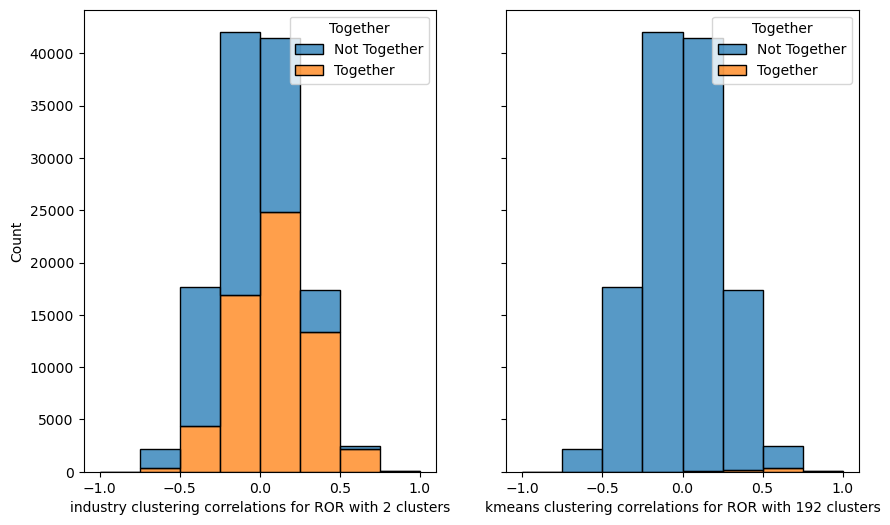

In [19]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR with 2 clusters")
axarr[1].set_xlabel("kmeans clustering correlations for ROR with 192 clusters")

best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])
print(best_cluster_ind)
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500.clusters[best_cluster_ind], ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500.scores['Silhouette'][20:])
print(best_cluster_ind)
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500.clusters[best_cluster_ind], ax = axarr[1])


In [ ]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

best_cluster_ind = np.argmax(kmeansSP500.scores['CalinskiHarabasz'])
#best_cluster_ind = 3
print(best_cluster_ind)
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = kmeansSP500.clusters[best_cluster_ind], ax = axarr[1])


In [27]:
import plotly.graph_objects as go

clusters = kmeansSP500.clusters[best_cluster_ind]
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns

fig = go.Figure(data = [go.Scatter3d(
    x = final_prices[cols[0]],
    y = final_prices[cols[1]],
    z = final_prices[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 4,
        color = final_prices['cluster'],
        colorscale = 'spectral',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()


In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")

closing_prices = closing_prices
ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))

clusters = industry_clusters
name_to_num = {name : i for (i, name) in enumerate(set(industry_clusters.values()))}
clusters = {tick : name_to_num[industry_clusters[tick]] for tick in industry_clusters.keys()}
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns


fig = go.Figure(data = [go.Scatter3d(
    x = final_prices[cols[0]],
    y = final_prices[cols[1]],
    z = final_prices[cols[2]],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = final_prices[cols[3]],
        colorscale = 'deep',
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    scene = dict(
        xaxis_title = "returns 1",
        yaxis_title = "returns 2",
        zaxis_title = "returns 3"
    ),
    margin = dict(l = 0, r = 0, t= 0)
)

fig.show()

As we can see, Kmeans on its own cannot beat the baseline model of industry clustering for risk-adjusted returns, which are the most useful for financial modeling.

There are two possible alternate approaches. 
- The first is to cluster *within* each industry cluster, and to refine the industry clustering. 
- The second is to try to remove the influence of "industry" on the sharpe rates of return, and then to try clustering again.

# Clustering using Dendrograms

In [105]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
from concurrent import futures
import numpy as np
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans


In [106]:
result = linkage(ROR.T.values, metric='cityblock', method='average')

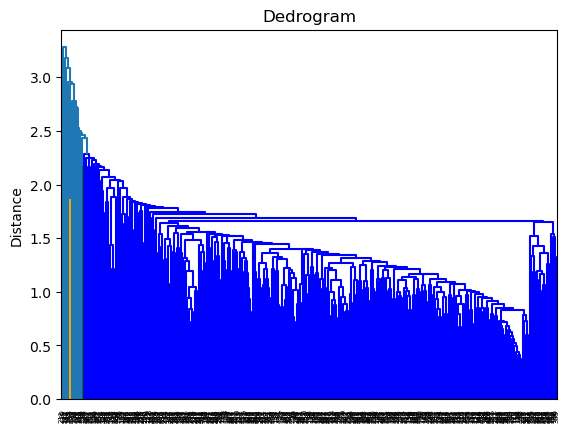

In [107]:
color_list = ["orange", "green", "blue"]
set_link_color_palette(color_list)
dendrogram(result)
plt.title("Dedrogram")
plt.ylabel("Distance")
plt.show()

# Clustering Using TSNE

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(497, 2)


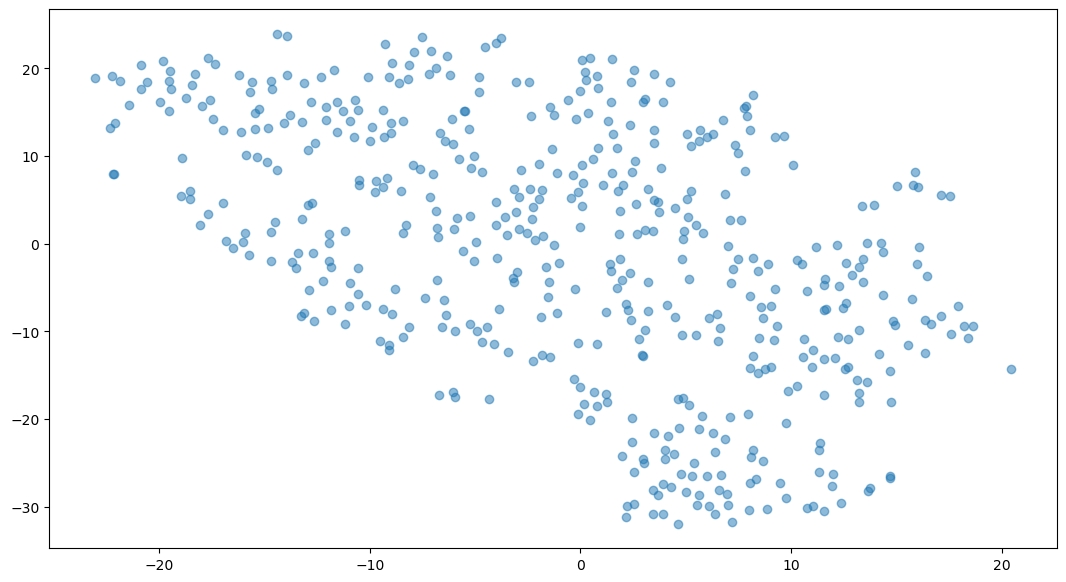

In [108]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")

closing_prices = closing_prices
ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))[-4:]
#ROR = l2_normalization(ROR)

tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(ROR.T)
print(X_reduced.shape)
"""

fig = go.Figure(data = [go.Scatter3d(
    x = X_reduced[:, 0],
    y = X_reduced[:, 1],
    z = X_reduced[:, 2],
    mode = 'markers',
    marker = dict(
        size = 5,
        opacity = 0.8
    )
)])

fig.update_layout(
    title = "3D visualization of clusters",
    margin = dict(l = 0, r = 0, t= 0)
)
"""

plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, -1}


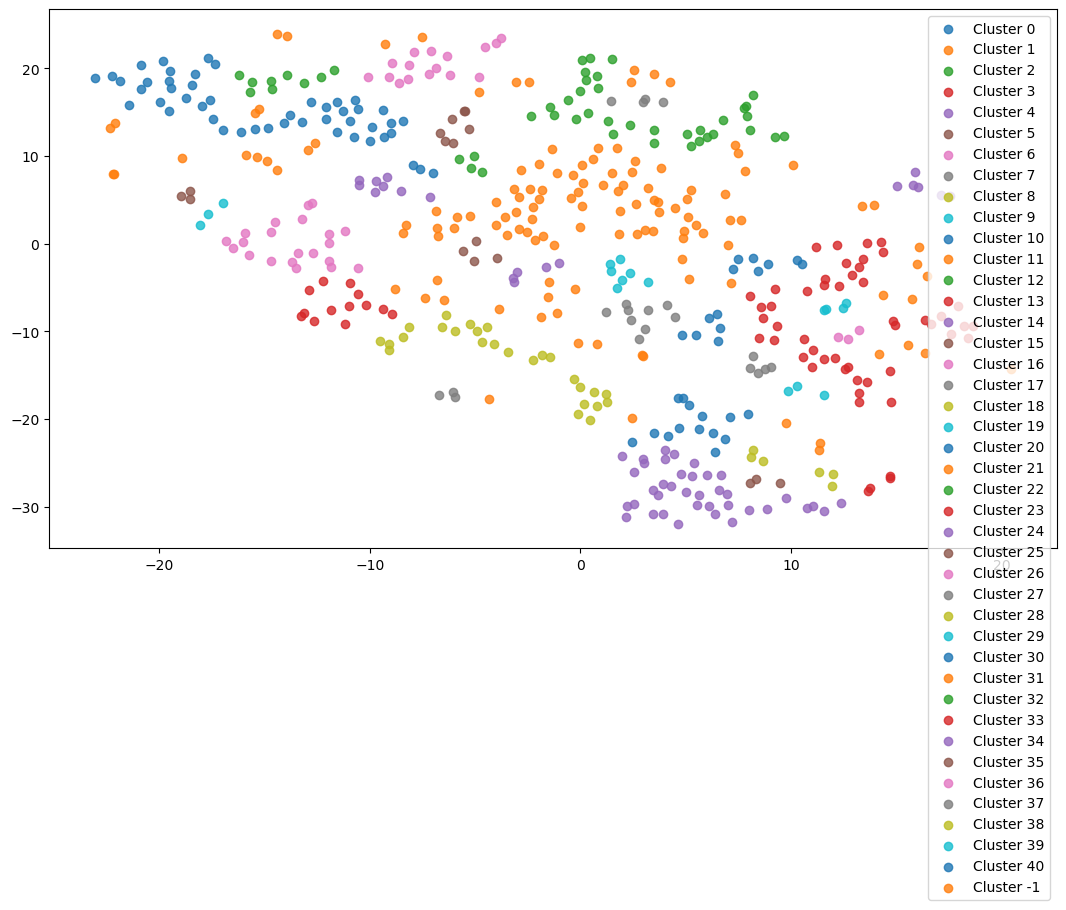

In [109]:
clustering = DBSCAN(eps=1.6, min_samples=3).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


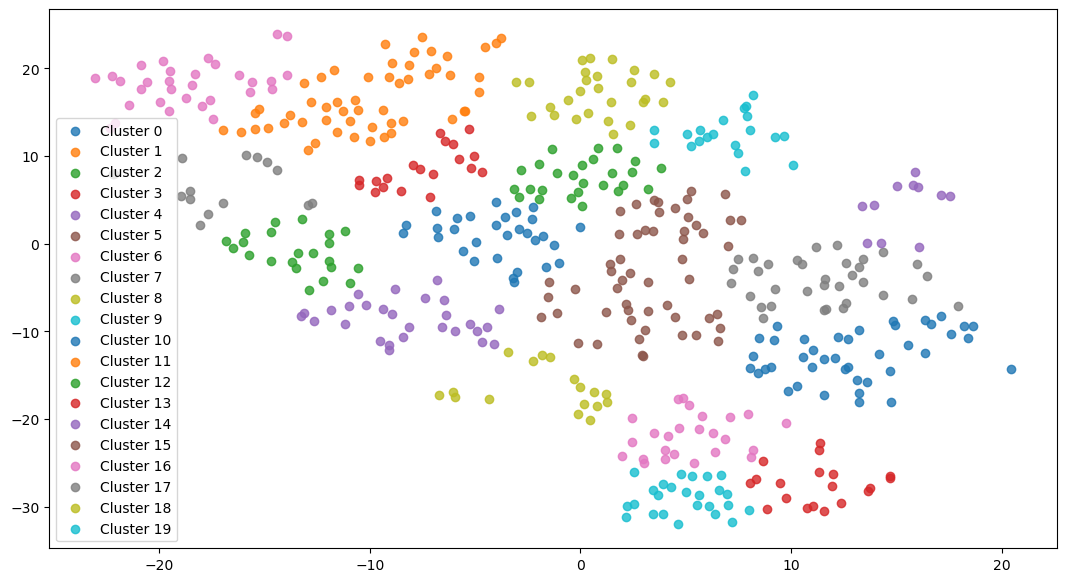

In [110]:
clustering = KMeans(n_clusters=20).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

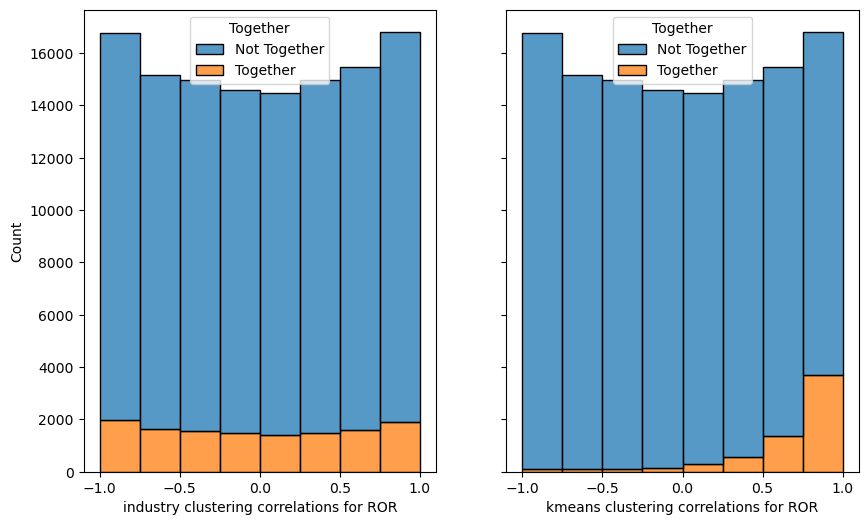

In [111]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}, ax = axarr[1])

<AxesSubplot:xlabel='2023-08-01 00:00:00-04:00', ylabel='2023-09-01 00:00:00-04:00'>

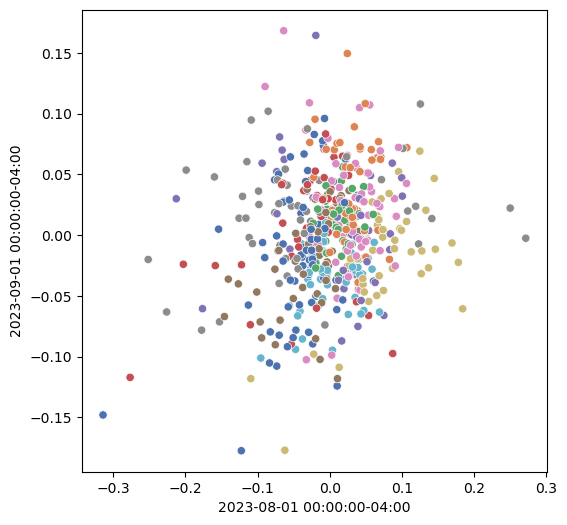

In [112]:
final_prices = ROR.T
final_prices["cluster"] = list(clusters.values())
cols = final_prices.columns
f, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(data = final_prices, x = cols[0], y = cols[1], hue = 'cluster', palette = 'deep', ax = ax, legend = False)

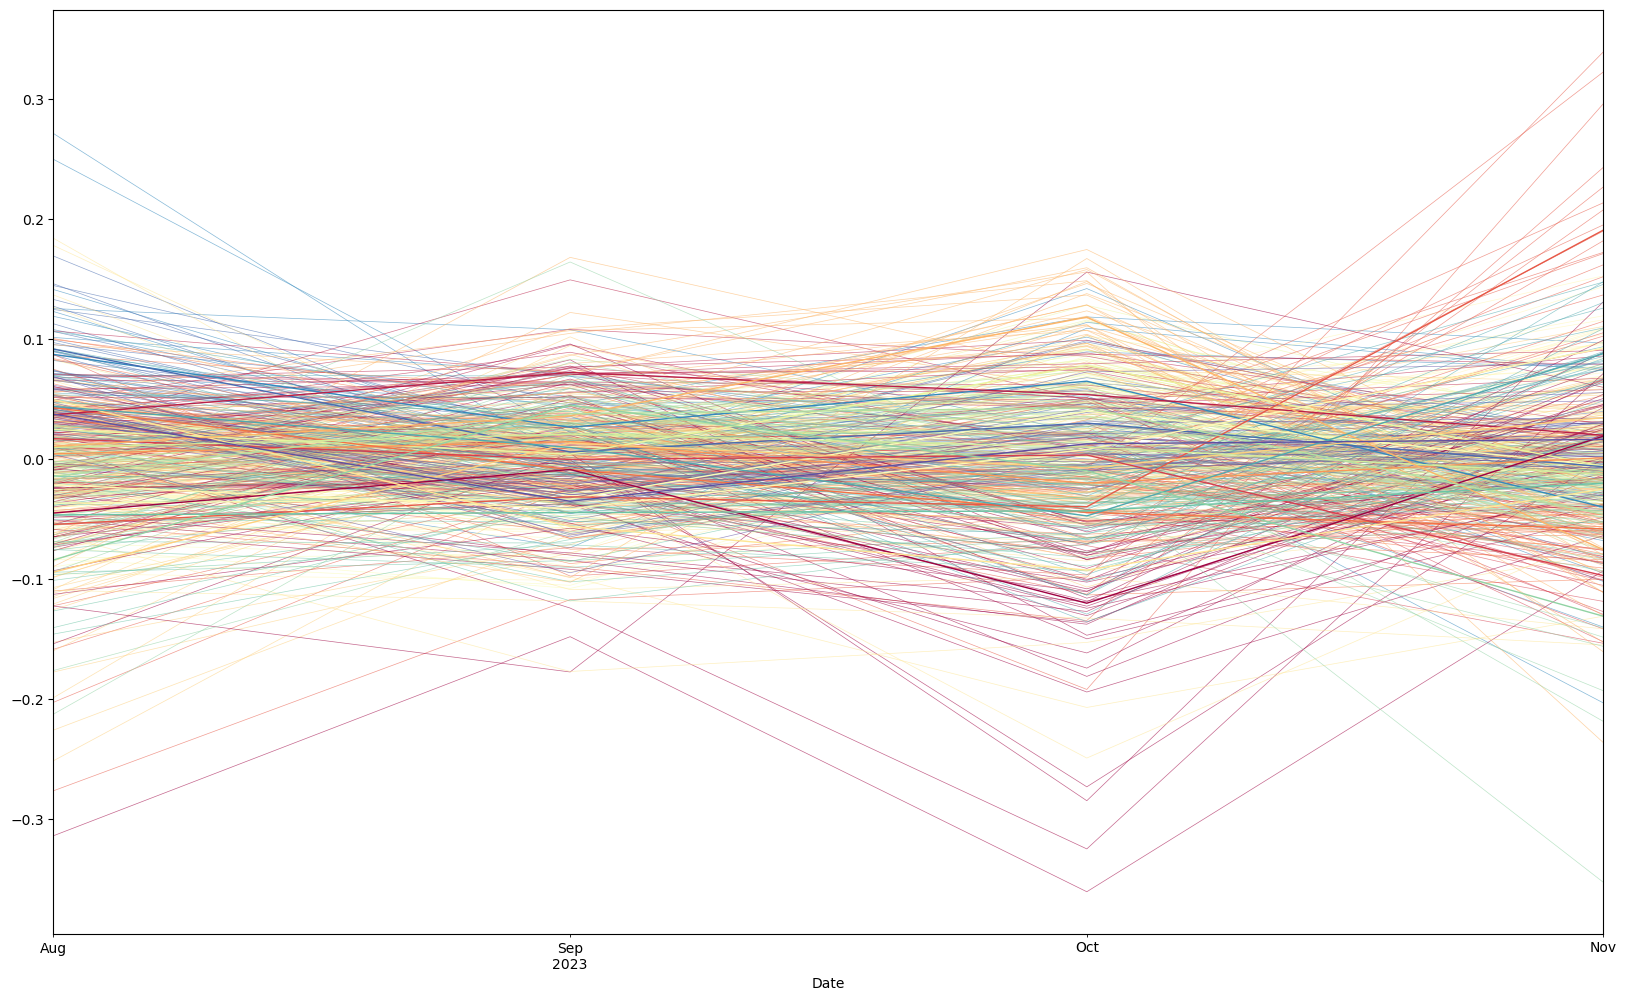

In [113]:
clust_to_tick = {label : [tick for tick in clusters.keys() if clusters[tick] == label] for label in clusters.values()}

fig, ax = plt.subplots(figsize = (20,12))

for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    ROR[clust_to_tick[i]].plot(legend = False, color = color, ax=ax, alpha = 0.6, linewidth = 0.5)
for i in clust_to_tick.keys():
    color = plt.get_cmap('Spectral')(i/(len(clust_to_tick.keys())-1))
    ROR[clust_to_tick[i]].mean(axis = 1).plot(legend = False, color = color, ax=ax, alpha = 1, linewidth = 1)

# Embedding with TSlearn and TSNE

In [122]:
import tslearn as ts
from tslearn.metrics import dtw, cdist_dtw
import pandas as pd

In [123]:
closing_prices = pd.read_pickle("./data/dataframes/closing_prices/closing_prices_monthly.pkl")

closing_prices = closing_prices
ROR = closing_prices.pct_change().dropna()
ROR = industry_adjust(market_adjust(ROR), list(industry_clusters.values()))
DTW = cdist_dtw(ROR.T)

In [124]:
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(DTW)
print(X_reduced.shape)

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(497, 2)


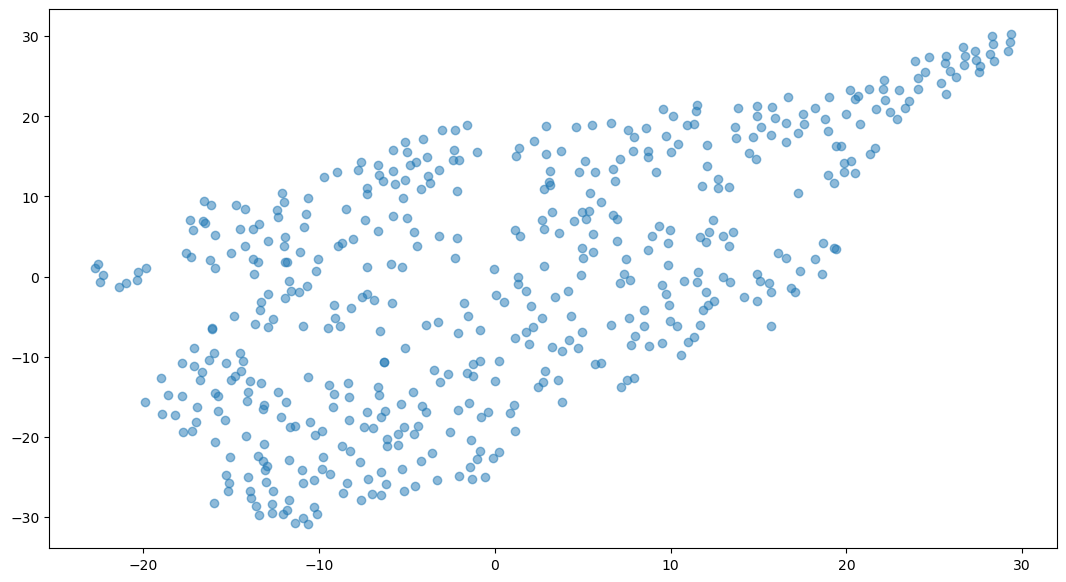

In [125]:
plt.figure(figsize=(13, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}


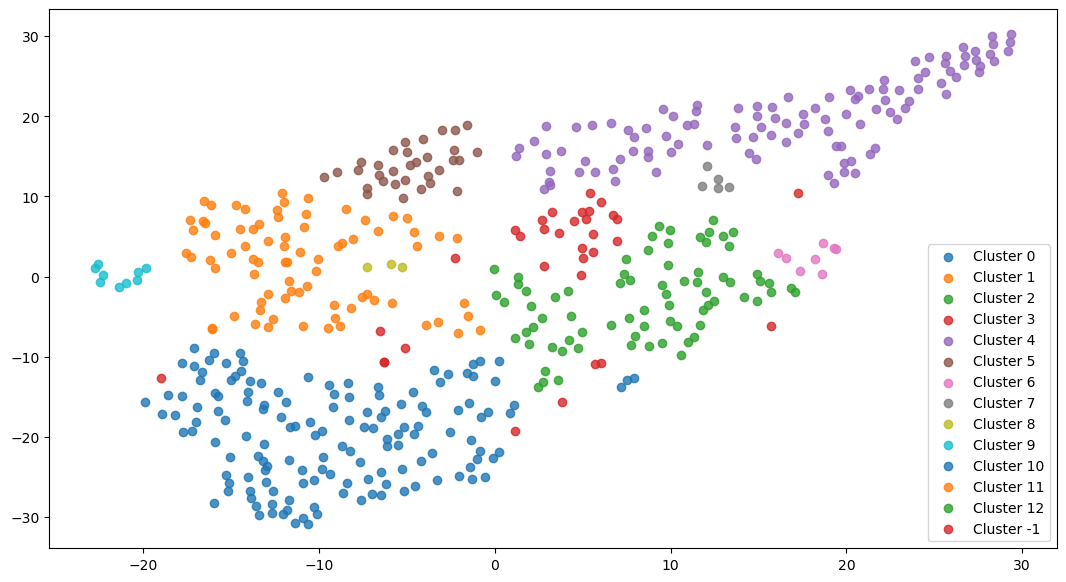

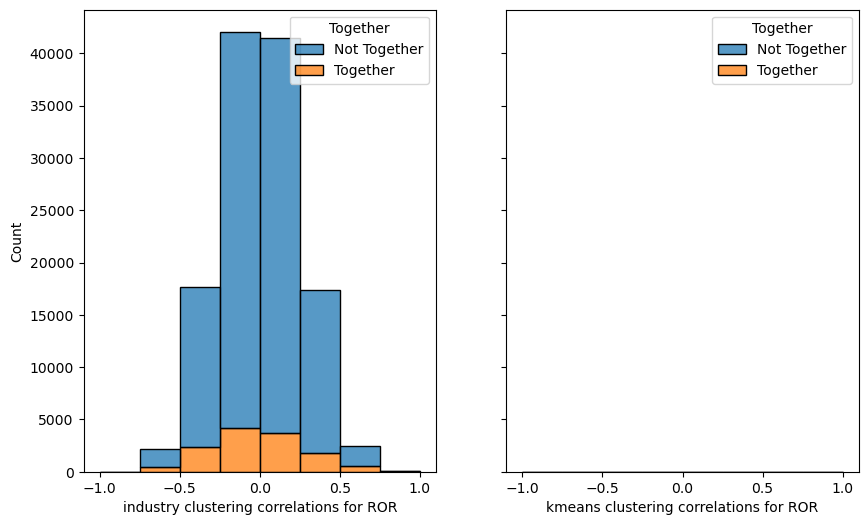

In [118]:
clustering = DBSCAN(eps=2, min_samples=3).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}
correlation_histogram(ROR.iloc[:,[1*(l>0) for l in labels_dbscan]], bins = np.linspace(-1,1,9), clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}, ax = axarr[1])

In [119]:
ROR.iloc[:, [1,4]]

Ticker,AOS,ACN
Date,,
2022-01-01 00:00:00-05:00,-0.043484,-0.045831
2022-02-01 00:00:00-05:00,-0.084990,-0.076451
2022-03-01 00:00:00-05:00,-0.096665,0.039165
2022-04-01 00:00:00-04:00,-0.020495,0.000657
2022-05-01 00:00:00-04:00,0.036241,-0.026173
2022-06-01 00:00:00-04:00,-0.007810,0.032747
2022-07-01 00:00:00-04:00,0.039339,-0.045344
2022-08-01 00:00:00-04:00,-0.068886,0.003760
2022-09-01 00:00:00-04:00,-0.051047,0.002428


c:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



{0, 1, 2, 3, 4, 5, 6}


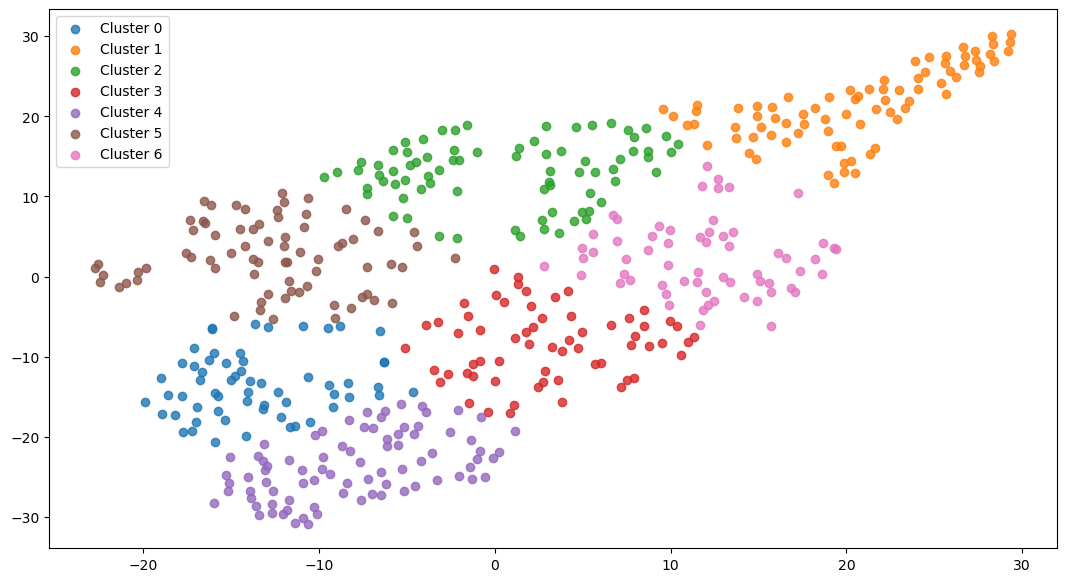

In [120]:
clustering = KMeans(n_clusters=7).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13, 7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

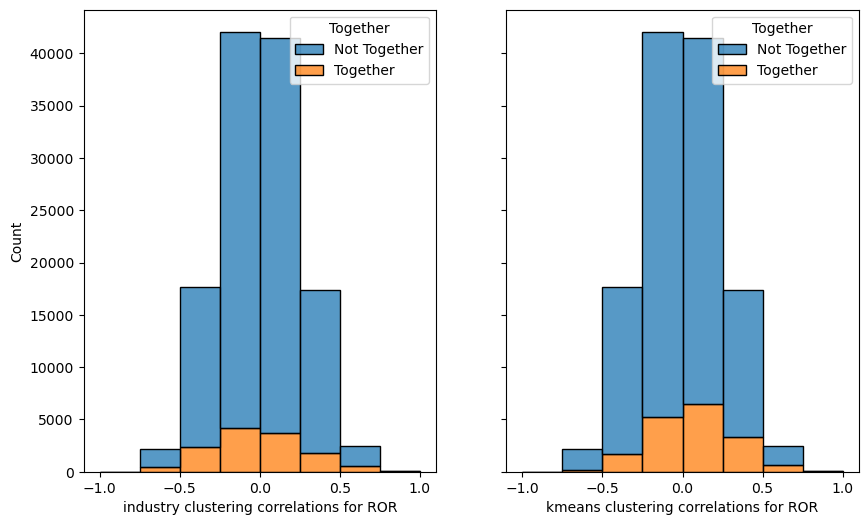

In [121]:
f, axarr = plt.subplots(1,2, sharey = True, figsize=(10,6))

axarr[0].set_xlabel("industry clustering correlations for ROR")
axarr[1].set_xlabel("kmeans clustering correlations for ROR")

correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = industry_clusters, ax = axarr[0])

clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}
correlation_histogram(ROR, bins = np.linspace(-1,1,9), clusters = {tick : label for (tick, label) in zip(ROR.columns, labels_dbscan)}, ax = axarr[1])